# Gage Data Retrieval Tool

In [7]:
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles, LayersControl, MarkerCluster, Popup, Icon, WidgetControl, ImageOverlay, DrawControl
from bqplot import Axis, LinearScale, Lines, Figure, Toolbar, DateScale, Scatter
import numpy as np
import ipywidgets as widgets
import datetime
import hhc_tools
import matplotlib.pyplot as plt
import sys
import warnings
import os
import glob
import subprocess
from tkinter import Tk, filedialog
warnings.filterwarnings('ignore')

workdir=os.getcwd()
####CALLABLE FUNCTIONS####

def dec_deg(degs,mins,secs):
    return np.round(degs + mins/60 + secs/3600,4)

def initialize_arrays():
    global dlist_NOAA, vlist_NOAA, dlist_USGS, vlist_USGS, dlist_USACE, vlist_USACE
    dlist_NOAA=[]
    vlist_NOAA=[]
    dlist_USGS=[]
    vlist_USGS=[]
    dlist_USACE=[]
    vlist_USACE=[]
    
def NOAA_download(*args,**kwargs, ):
    global dlist_NOAA, vlist_NOAA
    output_message.clear_output()

    with output_message:
        try:
            start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y%m%d %H:00")
            end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y%m%d %H:00")
            try:
                hhc_tools.NOAA_gage_data_request(begin_date=start,
                                                end_date=end,
                                                station=NOAA_gages[str(kwargs.get("coordinates"))][1],                           
                                                product="water_level",
                                                interval="60", 
                                                units="english", 
                                                time_zone="gmt", 
                                                datum="NAVD")
            except:
                hhc_tools.NOAA_gage_data_request(begin_date=start,
                                                end_date=end,
                                                station=NOAA_gages[str(kwargs.get("coordinates"))][1],                           
                                                product="water_level",
                                                interval="60", 
                                                units="english", 
                                                time_zone="gmt", 
                                                datum="MSL")

            dlist_NOAA,vlist_NOAA=hhc_tools.csvParseToLists("gage_data/"+NOAA_gages[str(kwargs.get("coordinates"))][1]+'.csv')
            vlist_NOAA=[float(i) if i else "NaN" for i in vlist_NOAA]
            print("Downloading Gage Data")
        except:
            if (start_date.value == None) or (start_date.value == None):
                print("Input dates")
            else:
                print("Something Wrong")
                
def USGS_download(*args,**kwargs, ):
    global dlist_USGS, vlist_USGS
    output_message.clear_output()
    with output_message:
        try:
            start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
            end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
            dlist_USGS,vlist_USGS=hhc_tools.USGS_gage_data_request(begin_date=start,
                                                                   end_date=end,
                                                                   site_no=USGS_gages[str(kwargs.get("coordinates"))][1])

            vlist_USGS=[float(i) if i else "NaN" for i in vlist_USGS]

            print("Downloading USGS Gage Data")
        except:
            if (start_date.value == None) or (start_date.value == None):
                print("Input dates")
            else:
                print("Something Wrong")

def USACE_download(*args,**kwargs, ):
    global dlist_USACE, vlist_USACE
    output_message.clear_output()
    with output_message:
        
        start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
        end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
        try:
            dlist_USACE, vlist_USACE=hhc_tools.USACE_gage_data_request(start,
                                                                       end,
                                                                       USACE_gages[str(kwargs.get("coordinates"))][1],
                                                                       rating_curves_dict[USACE_gages[str(kwargs.get("coordinates"))][2]],
                                                                       variable="HG",)
            print("Downloading USACE Gage Data")
        except:
            raise

def NWS_forecast_download(*args,**kwargs, ):
    global dlist_NWS_forecast, vlist_NWS_forecast
    output_message.clear_output()
    with output_message:
        if datetime.date.today()<end_date.value:
            try:
                dlist_NWS_forecast, vlist_NWS_forecast = hhc_tools.NWS_gage_data_request_forecast(USGS_gages[str(kwargs.get("coordinates"))][2],
                                                                                                  USGS_gages[str(kwargs.get("coordinates"))][1],
                                                                                                  rating_curves_dict[USGS_gages[str(kwargs.get("coordinates"))][2]])
                print("Downloading USGS Gage Data Forecast")
            except:
                try:
                    dlist_NWS_forecast, vlist_NWS_forecast = hhc_tools.NWS_gage_data_request_forecast(USACE_gages[str(kwargs.get("coordinates"))][2],
                                                                                                      USACE_gages[str(kwargs.get("coordinates"))][1],
                                                                                                      rating_curves_dict[USACE_gages[str(kwargs.get("coordinates"))][2]])
                    print("Downloading USACE Gage Data Forecast")                
                except:
                    dlist_NWS_forecast=[]
                    vlist_NWS_forecast=[]
                    print("NWS Forecast unavailable")

def ADCIRC_forecast_download(*args,**kwargs,):

    global dlist_ADCIRC_forecast, vlist_ADCIRC_forecast
    output_message.clear_output()
    with output_message:
        coords=kwargs.get("coordinates")
        print(coords)
        
        if datetime.date.today()<end_date.value:
            try:
                print("Reading fort.63.nc")
                dlist_ADCIRC_forecast, vlist_ADCIRC_forecast = hhc_tools.get_adcirc_time_series(coords[0],
                                                                                                coords[1],
                                                                                                CERA_data_path.value)
                np.savetxt("gage_data/"+NOAA_gages[str(kwargs.get("coordinates"))][1]+"_forecast.csv", np.c_[dlist_ADCIRC_forecast, vlist_ADCIRC_forecast], fmt="%s,%s")
                print("Extracted ADCIRC Forecast at gage location")
            except:
                raise
                
def update_chart_NOAA(*args,**kwargs,):
    global lines, figure
    with output_message:
        try:
            sc_x.min=start_date.value
            sc_x.max=end_date.value
            lines.x=[]
            lines.y=[]
            lines_forecast.x=[]
            lines_forecast.y=[]
            lines.x=np.array(dlist_NOAA[:]).astype('datetime64')
            lines.y=vlist_NOAA
            lines.y=[float(i) if i else "NaN" for i in lines.y]
            figure.title="Stage"
            ax_y.label="ft NAVD"
            try:
                lines_forecast.x=np.array(dlist_ADCIRC_forecast[:]).astype('datetime64')
                lines_forecast.y=vlist_ADCIRC_forecast
                lines_forecast.y=[float(i) if i else "NaN" for i in lines_forecast.y]
                lines_forecast.colors=["#FFA233"]
                
            except:
                raise
#            force_update()
        except:
            pass

def update_chart_USGS(*args,**kwargs,):
    global lines, figure
    with output_message:
        try:
            sc_x.min=start_date.value
            sc_x.max=end_date.value
            lines.x=[]
            lines.y=[]
            lines_forecast.x=[]
            lines_forecast.y=[]
            lines.x=np.array(dlist_USGS[:]).astype('datetime64')
            lines.y=vlist_USGS
            lines.y=[float(i) if i else "NaN" for i in lines.y]
            figure.title="Flow"
            ax_y.label="cfs"
            try:
                lines_forecast.x=np.array(dlist_NWS_forecast[:]).astype('datetime64')
                lines_forecast.y=vlist_NWS_forecast
                lines_forecast.y=[float(i) if i else "NaN" for i in lines_forecast.y]
                lines_forecast.colors=["#FFA233"]  
            except:
                raise
        except:
            pass
        
def update_chart_USACE(*args,**kwargs,):
    global lines, figure
    with output_message:
        try:   
            sc_x.min=start_date.value
            sc_x.max=end_date.value
            lines.x=[]
            lines.y=[]
            lines_forecast.x=[]
            lines_forecast.y=[]
            lines.x=np.array(dlist_USACE[:]).astype('datetime64')
            lines.y=vlist_USACE
            lines.y=[float(i) if i else "NaN" for i in lines.y]
            figure.title="Flow"
            ax_y.label="cfs"
            try:
                lines_forecast.x=np.array(dlist_NWS_forecast[:]).astype('datetime64')
                lines_forecast.y=vlist_NWS_forecast
                lines_forecast.y=[float(i) if i else "NaN" for i in lines_forecast.y]
                lines_forecast.colors=["#FFA233"]  
            except:
                raise
            
            
        except:
            pass
        
def force_update(*args,**kwargs,):
    global lines, dlist_NOAA, vlist_NOAA
    output_message.clear_output()
    with output_message:
        sc_x.min=start_date.value
        sc_x.max=end_date.value
        lines.x=np.array(dlist_NOAA[:2]).astype('datetime64')
        lines.y=vlist_NOAA[:2]
        figure = Figure(marks=[lines,lines_forecast], axes=[ax_x, ax_y], title='Stage')
        lines.x=np.array(dlist_NOAA[:]).astype('datetime64')
        lines.y=vlist_NOAA[:]
        try:
            lines_forecast.x=np.array(dlist_ADCIRC_forecast[:]).astype('datetime64')
            lines_forecast.y=vlist_ADCIRC_forecast
            lines_forecast.y=[float(i) if i else "NaN" for i in lines_forecast.y]
            lines_forecast.colors=["#FFA233"] 
        except:
            raise
                
def flood_fight_mode_change(value):
    global m
    if value["new"]==True:
        m.substitute_layer(lightmap,darkmap)
        m.add_layer(precip_QPE)
#        m.add_layer(precip_QPF)
        start_date.value=datetime.date.today()+ datetime.timedelta(days=-4)
        end_date.value=datetime.date.today()+datetime.timedelta(days=4)
    else:
#        m.remove_layer(precip_QPF)
        m.remove_layer(precip_QPE)
        m.substitute_layer(darkmap,lightmap)
        start_date.value=datetime.date(2021, 1, 1)
        end_date.value=datetime.date(2021, 1, 2)
        
def plot_precip(data,qpe_or_qpf='qpe'):
    import matplotlib.pylab as pl
    from matplotlib.colors import ListedColormap
    cmap = pl.cm.gist_ncar
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    my_cmap = ListedColormap(my_cmap)
    files = glob.glob('//precip//png//*')
    for f in files:
        os.remove(f)

    for i in range(len(data[2])):
        plt.pcolormesh(data[0]-360, data[1],data[2][i],cmap=my_cmap)
        plt.axis('off')
        plt.savefig('precip//png//'+qpe_or_qpf+f"{i:04d}.png",transparent=True,bbox_inches='tight', pad_inches=0,dpi=100)
        plt.clf()
    if qpe_or_qpf=='qpe':
        stream=subprocess.Popen("del qpe.mov",shell=True)
        stream.wait()
        stream=subprocess.Popen("del qpe.gif",shell=True)
        stream.wait()
        stream=subprocess.Popen('ffmpeg -i "precip\png\qpe%4d.png" -vcodec prores_ks -pix_fmt yuva444p10le -profile:v 4444 -q:v 50 -filter:v "setpts=2.5*PTS" qpe.mov')
        stream.wait()
        stream=subprocess.Popen('ffmpeg -i qpe.mov -lavfi split[v],palettegen,[v]paletteuse qpe.gif')
        
    else:
        stream=subprocess.Popen("del qpf.mov",shell=True)
        stream.wait()
        stream=subprocess.Popen("del qpf.gif",shell=True)
        stream.wait()
        stream=subprocess.Popen('ffmpeg -i "precip\png\qpf%4d.png" -vcodec prores_ks -pix_fmt yuva444p10le -profile:v 4444 -q:v 50 -filter:v "setpts=2.5*PTS" qpf.mov')
        stream.wait()
        stream=subprocess.Popen('ffmpeg -i qpf.mov -lavfi split[v],palettegen,[v]paletteuse qpf.gif')

def QPF_download(*args,**kwargs,):
    output_message.clear_output()
    with output_message:
        update_QPF_button.disabled=True
        print("Downloading latest QPF")
        hhc_tools.getQPF()
        print("Finished. Generating QPF layer") 
        qpf_data=hhc_tools.stack_gribs_qpf()
        plot_precip(qpf_data, 'qpf')
        print("Done")
        update_QPF_button.disabled=False
    
def QPE_download(*args,**kwargs,):
    output_message.clear_output()
    with output_message:
        update_QPE_button.disabled=True
        print("Downloading latest QPE")
        hhc_tools.getQPE()
        hhc_tools. QPE_unzip()
        print("Finished. Generating QPE layer")        
        qpe_data=hhc_tools.stack_gribs_qpe()
        plot_precip(qpe_data, 'qpe')  
        print("Done")
        update_QPE_button.disabled=False

def CERA_download(*args,**kwargs,):
    global CERA_data_path
    output_message.clear_output()
    with output_message:
        if datetime.date.today()>end_date.value:
            CERA_download_button.disabled=True
            year=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y")
            event=CERA_event.value
            mesh=CERA_mesh.value
            recent_path=hhc_tools.retrieve_recent_advisory_LSU(year,event,mesh,files=["maxele.63.nc","fort.63.nc"])
            CERA_data_path.value=recent_path+"fort.63.nc"
            CERA_download_button.disabled=False

def select_adcirc_data_path(*args,**kwargs,):
    global CERA_data_path
    output_message.clear_output()
    with output_message:
        global CERA_data_path
        root = Tk()
        root.withdraw() # Hide the main window.
        root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
        CERA_data_path.value = filedialog.askopenfilename(multiple=True)[0] # List of selected files will be set button's file attribute.
        
        
def load_ras(*args,**kwargs,):
    import rascontrol
    global ras_prj, plan_selection_drop_control, run_ras_button_control
    output_message.clear_output()
    with output_message:
        try:
            m.remove_control(plan_selection_drop_control)
            m.remove_control(run_ras_button_control)
        except:
            pass

        root = Tk()
        root.withdraw() # Hide the main window.
        root.call('wm', 'attributes', '.', '-topmost', True) # Raise the root to the top of all windows.
        ras_prj = filedialog.askopenfilename(multiple=True) # List of selected files will be set button's file attribute.
        print(ras_prj, " loaded.")
        rc = rascontrol.RasController(version='5X')
        rc.open_project(ras_prj[0])
        plan_list=rc.get_plans()
        rc.close()
        plan_selection_drop.options=plan_list

        plan_selection_drop_control = WidgetControl(widget=plan_selection_drop, position='topright')
        run_ras_button_control = WidgetControl(widget=run_ras_button, position='topright')
        m.add_control(plan_selection_drop_control)
        m.add_control(run_ras_button_control)
        build_BC_connections()
    
def run_ras(*args,**kwargs,):
    output_message.clear_output()
    with output_message:
        hhc_tools.date_2_plan_file(datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%d%b%Y").upper(),
                                   datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%d%b%Y").upper(),
                                   plan_selection_drop.value.filename)
        
        BC_connections=np.loadtxt("BC_connections.csv",dtype=str)
        for BC in BC_connections:
            i=BC.split(",")
            print(i)
            if i[4]=='flow':
                hhc_tools.flow_gage_2_unsteady_flow_file(i[1],
                                                         hhc_tools.find_u_file(plan_selection_drop.value.filename),
                                                         i[0])
            elif i[4]=='stage':
                hhc_tools.stage_gage_2_unsteady_flow_file(i[1],
                                                          hhc_tools.find_u_file(plan_selection_drop.value.filename),
                                                          i[0])
            else:
                print(i[0], " could not be writted to unsteady flow file")
        
        try:
            bool(ras_prj[0])
            try:
                bool(plan_selection_drop.value)
            except:
                print("Select RAS plan")
                return
        except:
            print("Select RAS prj first.")
            return
            
        if bool(ras_prj[0]) == True:
            hhc_tools.run_ras(ras_prj[0],plan_selection_drop.value)
        else:
            print("Select RAS prj first.")
        
####WIDGETS####
m = Map(
    center=(30, -90),
    zoom=6
)

start_date=widgets.DatePicker(
    description='Start Date',
    disabled=False,
    value=datetime.date(2021, 1, 1)
)

end_date=widgets.DatePicker(
    description='End Date',
    disabled=False,
    value=datetime.date(2021, 1, 2)
)
     
update_graph_button = widgets.Button(
               description='Update Graph',
               disabled=False,
               button_style='',
               tooltip='Reload Graph',
               icon='area-chart'
)    

update_QPE_button = widgets.Button(
               description='Update QPE',
               disabled=False,
               button_style='',
               tooltip='Download latest QPE',
               icon='download'
)  

update_QPF_button = widgets.Button(
               description='Update QPF',
               disabled=False,
               button_style='',
               tooltip='Download latest QPF',
               icon='download'
)



flood_fight_mode = widgets.Checkbox(False, 
                                    description='Flood Fight Mode')

precip_QPE = ImageOverlay(name="QPE",
                          url='qpe.gif?'+str(int(np.random.random()*1000)),
                          bounds=((25.319561448076833, -98.791), 
                              (43.795361808256, -76.22287444310194)),
                          description="QPE")

precip_QPF = ImageOverlay(name="QPF",
                      url='qpf.gif?'+str(int(np.random.random()*1000)),
                      bounds=((20.190001, -130.10041425), 
                              (52.81117482, -60.89000636999998)),
                      description="QPE")

instructions=widgets.Textarea(description='Instructions:',
                              value="""1. Set date range (Maximum 30 days).\n2. Click gage marker to download data.\n3. Click button to show plot.""",
                              rows=3,
                              layout=widgets.Layout(width="400px"),
                              disabled=True)

load_ras_button = widgets.Button(
               description='Load RAS Project',
               disabled=False,
               button_style='',
               tooltip='Load RAS Project',
               icon='file'
)

run_ras_button = widgets.Button(
               description='Run RAS',
               disabled=False,
               button_style='',
               tooltip='Run Current Plan',
               icon='hand-o-right'
)

plan_selection_drop=widgets.Dropdown(
    options=[''],
    value='',
    description='RAS Plans:',
    disabled=False,
)


CERA_mesh = widgets.Dropdown(options=['LA_v20a-WithUpperAtch_chk','NEFLGAv12b','HSOFS','CenFlv7'],
                             layout=widgets.Layout(width='200px'))


CERA_event = widgets.Text(value='nam',
                          description='',
                          disabled=False,
                          layout=widgets.Layout(width='75px'))

CERA_data_path = widgets.Text(value='',
                                  description='',
                                  disabled=False,
                                  layout=widgets.Layout(width='200px'))

CERA_download_button = widgets.Button(description='Download adcirc',
                                      disabled=False,
                                      button_style='',
                                      tooltip='Download recent CERA run',
                                      icon='download'
)

CERA_data_path_button = widgets.Button(description='',
                                       disabled=False,
                                       button_style='',
                                       tooltip='adcirc data path',
                                       icon='hand-o-right',
                                       layout=widgets.Layout(width='50px')
)

CERA_buttons=widgets.HBox([ CERA_download_button,CERA_data_path_button])

tab = widgets.Tab()


sc_x = DateScale()#LinearScale()
sc_y = LinearScale()
ax_x = Axis(scale=sc_x, label='time',)
ax_y = Axis(scale=sc_y, orientation='vertical', label='value', tick_format='i')
lines = Lines(x=[], y=[], scales={'x': sc_x, 'y': sc_y})
lines_forecast = Lines(x=[], y=[], scales={'x': sc_x, 'y': sc_y})
figure = Figure(marks=[lines,lines_forecast], axes=[ax_x, ax_y], title='chart')
toolbar = Toolbar(figure=figure)


####MARKERS####

initialize_arrays()

"""gage dictionaries {location in decimal degrees: [name, gage_id_no for observed, gage name for nws forecast]


some gages dont have nws forcast name
"""

#NOAA gage location Name and ID
NOAA_gages = {str([dec_deg(29,27,0), dec_deg(-91,-20.3,0)]): ["amerada","8764227"],
              str([dec_deg(28,55.9,0), dec_deg(-89,-24.4,0)]): ["pilots_station","8760922"],
              str([dec_deg(29,33.1,0), dec_deg(-92,-18.3,0)]): ["freshwater_canal","8766072"],
              str([dec_deg(30,1.6,0), dec_deg(-90,-6.8,0)]): ["new_canal_station","8761927"],
              str([dec_deg(29,52.1,0), dec_deg(-89,-40.4,0)]): ["shell_beach","8761305"],
              str([dec_deg(29,15.8,0), dec_deg(-89,-57.4,0)]): ["grand_isle","8761724"],
              str([dec_deg(29,10.7,0), dec_deg(-89,-15.5,0)]): ["pilottown","8760721"],
              str([dec_deg(29,6.9,0), dec_deg(-90,-12.0,0)]): ["port_fourchon","8762075"],
              str([dec_deg(29,47.3,0), dec_deg(-90,-25.2,0)]): ["westbank1_bayou_gauche","8762482"],
              str([dec_deg(29,56.0,0), dec_deg(-90,-8.1,0)]): ["carrollton","8761955"],
              str([dec_deg(30,4.1,0), dec_deg(-90,-23.4,0)]): ["i10_bonnet_carre_floodway","8762483"],
              str([dec_deg(29,40.1,0), dec_deg(-91,-14.3,0)]): ["berwick_atchafalaya","8764044"],
              str([dec_deg(29,22.4,0), dec_deg(-91,-23.0,0)]): ["eugene_island","8764314"],
              str([dec_deg(29,46.1,0), dec_deg(-93,-20.6,0)]): ["calcasieu","8768094"],
              str([dec_deg(29,41.4,0), dec_deg(-93,-50.5,0)]): ["texas_point","8770822"],
              str([dec_deg(29,52.0,0), dec_deg(-93,-55.9,0)]): ["port_arthur","8770475"],
              str([dec_deg(29,58.8,0), dec_deg(-93,-52.9,0)]): ["rainbow_bridge","8770520"],
              str([dec_deg(30,11.4,0), dec_deg(-93,-18.0,0)]): ["bulk_terminal","8767961"],
              str([dec_deg(30,11.4,0), dec_deg(-93,-18.0,0)]): ["lake_charles","8767816"],
             }
#USGS gage location Name and ID
USGS_gages = {str([dec_deg(30,58,57),dec_deg(-91,-47,54)]): ["simmesport","07381490","smml1"],
              str([dec_deg(30,27,50), dec_deg(-90,-59,25)]): ["amite_denham_springs","07378500"],
              str([dec_deg(30,11,24), dec_deg(-92,-35,26)]):["mermentau","08012150"],
              str([dec_deg(30,53,20), dec_deg(-90,-50,40)]):["amite_darlington","07377000"],
              str([dec_deg(29,22,58), dec_deg(-90,-42,55)]):["bayou_grand_caillou","07381324"],
              str([dec_deg(29,41,33.4), dec_deg(-91,-12,42.6)]):["lower_atchafalaya","07381600 "],
              str([dec_deg(29,35,8), dec_deg(-91,-9,19)]):["bayou_penchant", "073816503"],
              str([dec_deg(29,40,6), dec_deg(-91,-5,59)]):["bayou_beouf_railroad", "073814675"],
              str([dec_deg(29,47,52), dec_deg(-90,-49,21)]):["bayou_lafourche", "07381000"],
              str([dec_deg(29,55,1), dec_deg(-90,-19,4)]):["davis_pond", "295501090190400"],
              str([dec_deg(29,41,56.8), dec_deg(-89,-59,19.9)]):["naomi_diversion_canal", "07380238"],
              str([dec_deg(29,51,12.8), dec_deg(-89,-54,27.7)]):["caernarvon", "295124089542100"],
              str([dec_deg(30,21,8), dec_deg(-89,-38,45)]):["pearl_river_nstl", "02492620"],
              str([dec_deg(30,34,13), dec_deg(-89,-48,40)]):["wilson_slough", "02492111"],
              str([dec_deg(30,37,45), dec_deg(-89,-53,50)]):["bogue_chitto_bush", "02492000"],
              str([dec_deg(30,47,35), dec_deg(-89,-49,15)]):["pearl_river_bogalusa", "02489500"],
              str([dec_deg(31,0,44), dec_deg(-90,-27,40)]):["tangipahoa_osyka", "07375280"],
              str([dec_deg(30,55,50), dec_deg(-90,-40,24)]):["tickfaw_liverpool", "07375800"],
              str([dec_deg(30,41,10), dec_deg(-90,-38,35)]):["tickfaw_montpelier", "07375960"],
              str([dec_deg(30,30,45), dec_deg(-91,-4,25)]):["comite", "07378000"],
              str([dec_deg(30,30,13), dec_deg(-90,-40,38)]):["tickfaw_holden", "07376000"],
              str([dec_deg(30,30,15), dec_deg(-90,-32,45)]):["natalbany_baptist", "07376500"],
              str([dec_deg(30,30,23), dec_deg(-90,-21,42)]):["tangipahoa_robert", "07375500"],
              str([dec_deg(30,32,5), dec_deg(-90,-58,50)]):["amite_magnolia", "07377300"],
              str([dec_deg(30,11,21.3), dec_deg(-90,-46,52.6)]):["new_river_canal", "073802284"],
              str([dec_deg(30,5,47), dec_deg(-91,-0,21)]):["bayou_lafourche_donaldsonville", "07380401"],
              str([dec_deg(29,52,45), dec_deg(-91,-35,10)]):["bayou_teche_adeline", "07385765"],
              str([dec_deg(30,13,2), dec_deg(-91,-59,34)]):["vermilion_surrey", "07386880"],
              str([dec_deg(30,18,13), dec_deg(-93,-44,37)]):["sabine_ruliff", "08030500"],
              str([dec_deg(30,59,48), dec_deg(-92,-40,25)]):["calcasieu_glenmora", "08013000"],
              str([dec_deg(32,26,50), dec_deg(-93,-35,40)]):["red_chute_bayou_sligo", "07349860"],
              
             }

#USACE gage location Name and ID



USACE_gages = {str([30.960,-91.664]): ["red_river_landing","01120","rrll1"],
              
              
              }


#rating curves dictionary to convert from stage to flow

rating_curves_dict={'smml1':[161.74,7046.5,45410],
                    'rrll1':[792.34,-45098.59,1139083.76],
                        }



#Build markers from dictionaries above
NOAA_Sites_d={}
USGS_Sites_d={}
USACE_Sites_d={}

for site in NOAA_gages:
    NOAA_Sites_d[NOAA_gages[site][0]] = Marker(location=(float(site[1:-1].split(',')[0]),
                                                         float(site[1:-1].split(',')[1])),
                                               title=NOAA_gages[site][0],
                                               draggable=False,
                                               icon=Icon(icon_url='./markers/LogoNWSLg.png',
                                                         icon_size=[20, 20], ),)

for site in USGS_gages:
    USGS_Sites_d[USGS_gages[site][0]] = Marker(location=(float(site[1:-1].split(',')[0]),
                                                         float(site[1:-1].split(',')[1])),
                                               title=USGS_gages[site][0],
                                               draggable=False,
                                               icon=Icon(icon_url='./markers/LogoUSGSLg.png',
                                                         icon_size=[20, 20], ),)

for site in USACE_gages:
    USACE_Sites_d[USACE_gages[site][0]] = Marker(location=(float(site[1:-1].split(',')[0]),
                                                         float(site[1:-1].split(',')[1])),
                                               title=USACE_gages[site][0],
                                               draggable=False,
                                               icon=Icon(icon_url='./markers/LogoUSACELg.png',
                                                         icon_size=[20, 20], ),)
    

NOAA_markers = MarkerCluster(name="NOAA Gages",
                             markers=(list(NOAA_Sites_d.values())
                                       ),)

USGS_markers = MarkerCluster(name="USGS Gages",
                             markers=(list(USGS_Sites_d.values())
                                       ),)

USACE_markers = MarkerCluster(name="USACE Gages",
                             markers=(list(USACE_Sites_d.values())
                                       ),)

####INTERACTION####
update_graph_button.on_click(force_update)
update_QPE_button.on_click(QPE_download)
update_QPF_button.on_click(QPF_download)
run_ras_button.on_click(run_ras)
load_ras_button.on_click(load_ras)
CERA_download_button.on_click(CERA_download)
CERA_data_path_button.on_click(select_adcirc_data_path)


for site in NOAA_Sites_d:
    NOAA_Sites_d[site].on_click(NOAA_download)
    NOAA_Sites_d[site].on_click(ADCIRC_forecast_download)
    NOAA_Sites_d[site].on_click(update_chart_NOAA)

    
for site in USGS_Sites_d:
    USGS_Sites_d[site].on_click(USGS_download)
    USGS_Sites_d[site].on_click(NWS_forecast_download)
    USGS_Sites_d[site].on_click(update_chart_USGS)
    
for site in USACE_Sites_d:
    USACE_Sites_d[site].on_click(USACE_download)
    USACE_Sites_d[site].on_click(NWS_forecast_download)
    USACE_Sites_d[site].on_click(update_chart_USACE)


flood_fight_mode.observe(flood_fight_mode_change,names='value')

update_graph_button_control = WidgetControl(widget=update_graph_button, position='topright')
date_picker_start_control = WidgetControl(widget=start_date)
date_picker_end_control = WidgetControl(widget=end_date)
figure_control = WidgetControl(widget=figure,position="bottomright",min_width=500,min_height=300)
instructions_control = WidgetControl(widget=instructions,position="bottomleft")#,min_width=500,min_height=400,)
toolbar_control = WidgetControl(widget=toolbar,position="bottomright")
flood_fight_mode_control=WidgetControl(widget=flood_fight_mode, position='topleft')
update_QPE_button_control = WidgetControl(widget=update_QPE_button, position='topright')
update_QPF_button_control = WidgetControl(widget=update_QPF_button, position='topright')
load_ras_button_control = WidgetControl(widget=load_ras_button, position='topright')

CERA_event_control = WidgetControl(widget=CERA_event, position='topright')
CERA_data_path_control = WidgetControl(widget=CERA_data_path, position='topright')
CERA_mesh_control = WidgetControl(widget=CERA_mesh, position='topright')
#CERA_download_button_control = WidgetControl(widget=CERA_download_button, position='topright')
#CERA_data_path_button_control = WidgetControl(widget=CERA_data_path_button, position='topright')
CERA_buttons_control = WidgetControl(widget=CERA_buttons,position='topright')
#run_ras_button_control = WidgetControl(widget=run_ras_button, position='topright')
#plan_selection_drop_control = WidgetControl(widget=plan_selection_drop, position='topright')



####ASSEMBLE LAYERS####
m.add_layer(basemap_to_tiles(basemaps.Esri.WorldImagery,))
darkmap=basemap_to_tiles(basemaps.CartoDB.DarkMatter,)
lightmap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik,)
#m.add_layer(darkmap)
m.add_layer(lightmap)


m.add_layer(NOAA_markers)
m.add_layer(USGS_markers)
m.add_layer(USACE_markers)
#m.add_layer(precip_QPF)
#m.add_layer(precip_QPE)
m.add_control(LayersControl())
m.scroll_wheel_zoom=True


m.add_control(update_graph_button_control)
m.add_control(date_picker_start_control)
m.add_control(date_picker_end_control)
m.add_control(figure_control)
m.add_control(toolbar_control)
m.add_control(instructions_control)
m.add_control(flood_fight_mode_control)
m.add_control(update_QPE_button_control)
m.add_control(update_QPF_button_control)
m.add_control(load_ras_button_control)

m.add_control(CERA_event_control)
m.add_control(CERA_mesh_control)
#m.add_control(CERA_download_button_control)
m.add_control(CERA_buttons_control)
m.add_control(CERA_data_path_control)
#m.add_control(CERA_data_path_button_control)

#m.add_control(run_ras_button_control)
#m.add_control(plan_selection_drop_control)

####GRID DISPLAY###
grid_layout = widgets.GridspecLayout(8, 8, justify_items='center')
grid_layout.layout.height = '900px'
#grid_layout.layout.width = '50%'

m.layout.width = 'auto'
m.layout.height = 'auto'
#figure.layout.width = #'auto'
figure.layout.height ="300px"# 'auto'

grid_layout[:7, :] = m
grid_layout[7, :] = output_message = widgets.Output()
#grid_layout[7,5:6] = plan_selection_drop
#display(grid_layout)




In [8]:
####BC Connection TAB#####


boundaries_header = "<h1 style='font-size:16px'>Boundaries</h1>"
gages_header = "<h1 style='font-size:16px'>Gage ID</h1>"
datum_shift_header = "<h1 style='font-size:16px'>Datum Shift</h1>"
multiplier_header = "<h1 style='font-size:16px'>Multiplier</h1>"

dates=[start_date,end_date]

headers=[widgets.HTML(value= boundaries_header,layout=widgets.Layout(width='200px')),
         widgets.HTML(value= gages_header,layout=widgets.Layout(width='200px')),
         widgets.HTML(value= datum_shift_header,layout=widgets.Layout(width='200px')),
         widgets.HTML(value= multiplier_header,layout=widgets.Layout(width='200px'))]

BC_connections_button = widgets.Button(
               description='Set BC Connections',
               disabled=False,
               button_style='',
               tooltip='Reload Graph',
               icon='refresh'
) 
dates_box=widgets.HBox(dates)
headers_box=widgets.HBox(headers)
connections_table=widgets.VBox([dates_box,headers_box,BC_connections_button])


gage_options=[None]
for site in NOAA_gages:
    gage_options.append(NOAA_gages[site])

for site in USGS_gages:
    gage_options.append(USGS_gages[site])

for site in USACE_gages:
    gage_options.append(USACE_gages[site])
            
def build_BC_connections():
    global connections_table,BC_list
    
    BC_list=hhc_tools.BC_list(hhc_tools.find_u_file(plan_selection_drop.value.filename))

    widgets.FloatText(
        value=0,
        description='',
        disabled=False
    )
    
    boundaries = [widgets.Label(value=i,layout=widgets.Layout(width='200px')) for i in BC_list]
    gages = [widgets.Dropdown(options=gage_options, layout=widgets.Layout(width='200px')) for i in range(len(BC_list))]


    datum_shift = [widgets.FloatText(value=0,
                                     description='',
                                     disabled=False,
                                     layout=widgets.Layout(width='200px')) for i in range(len(BC_list))]

    multiplier = [widgets.FloatText(value=1,
                                     description='',
                                     disabled=False,
                                     layout=widgets.Layout(width='200px')) for i in range(len(BC_list))]


    gages_box = widgets.VBox(gages)
    boundaries_box = widgets.VBox(boundaries)
    datum_shift_box = widgets.VBox(datum_shift)
    multiplier_box  = widgets.VBox(multiplier)


    
    connections_table=widgets.HBox([boundaries_box,gages_box, datum_shift_box,multiplier_box])
    connections_table=widgets.VBox([dates_box,headers_box,connections_table,BC_connections_button])
    
    tab.children=(grid_layout,connections_table)


def set_BC_connections(*args,**kwargs):
    output_message.clear_output()
    with output_message:
        BC_connections_table=np.zeros(shape=(len(BC_list),5),dtype=np.dtype('U100'))

        for i in range(len(connections_table.children[2].children)):
            for j in range(len(connections_table.children[2].children[i].children)):
                if type(connections_table.children[2].children[i].children[j].value)==list:
                    BC_connections_table[j,i]=connections_table.children[2].children[i].children[j].value[1]
                    if any(connections_table.children[2].children[i].children[j].value[1] in sublist for sublist in list(NOAA_gages.values())) == True:
                        BC_connections_table[j,4] = 'stage'
                    elif  any(connections_table.children[2].children[i].children[j].value[1] in sublist for sublist in list(USGS_gages.values())) == True:
                        BC_connections_table[j,4] = 'flow'
                    else:
                        BC_connections_table[j,4] = None
                else:
                    BC_connections_table[j,i]=connections_table.children[2].children[i].children[j].value                
        np.savetxt("BC_connections.csv",BC_connections_table,delimiter=',',fmt='%s')
        print("BC connections file saved")

def download_BC_data(*args,**kwargs):
    output_message.clear_output()
    with output_message:
        BC_connections_button.disabled=True
        BC_connections=np.loadtxt("BC_connections.csv",dtype=str)
        for BC in BC_connections:
            i=BC.split(",")
            if any(i[1] in sublist for sublist in list(NOAA_gages.values())) == True:
                start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y%m%d %H:00")
                end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y%m%d %H:00")
                try:
                    hhc_tools.NOAA_gage_data_request(begin_date=start,
                                                    end_date=end,
                                                    station=i[1],                           
                                                    product="water_level",
                                                    interval="60", 
                                                    units="english", 
                                                    time_zone="gmt", 
                                                    datum="NAVD")
                    print(i[1]," downloaded")
                    
                except:
                    try:
                        hhc_tools.NOAA_gage_data_request(begin_date=start,
                                                        end_date=end,
                                                        station=i[1],                           
                                                        product="water_level",
                                                        interval="60", 
                                                        units="english", 
                                                        time_zone="gmt", 
                                                        datum="MSL")
                        print(i[1]," downloaded")
                    except:
                        print("NOAA download failed for ", i[1])
            elif any(i[1] in sublist for sublist in list(USGS_gages.values())) == True:
                try:
                    start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
                    end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
                    dlist_USGS,vlist_USGS=hhc_tools.USGS_gage_data_request(begin_date=start,
                                                                           end_date=end,
                                                                           site_no=i[1])
                    print(i[1]," downloaded")
                    
                except:
                    print("USGS download failed for ", i[1])
                
            elif any(i[1] in sublist for sublist in list(USACE_gages.values())) == True:
                try:
                    start=datetime.datetime.strptime(str(start_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
                    end=datetime.datetime.strptime(str(end_date.value), "%Y-%m-%d").strftime("%Y-%m-%d")
                    dlist_USGS,vlist_USGS=hhc_tools.USGS_gage_data_request(begin_date=start,
                                                                           end_date=end,
                                                                           site_no=i[1])
                    print(i[1]," downloaded")
                    
                except:
                    print("USGS download failed for ", i[1])
            else:
                print(i[1],"gage not found in gage list")
        BC_connections_button.disabled=False


BC_connections_button.on_click(set_BC_connections)
BC_connections_button.on_click(download_BC_data)

In [9]:
tab.children=(grid_layout,connections_table)
tab.set_title(0, "Data Downloader")
tab.set_title(1, "BC Connections")
display(tab)

In [ ]:
import shutil
import gzip
def QPE_unzip(interval=None,destination='precip/qpe/'):
    try:
        os.mkdir(destination+"grib")
    except:
        print(destination+"grib already exists.")
        
    try:
        os.mkdir(destination+"../temp")
    except:
        print(destination+"../temp already exists.")
        
    zipped_filenames=[os.path.basename(x) for x in glob.glob(destination+'gz/*')]
    print(zipped_filenames)
    filenames=[os.path.basename(x) for x in glob.glob(destination+'grib/*')]
    print(filenames)
    filenames = [x+".gz" for x in filenames if "gz" not in x]
    print(filenames)
    filenames = list(set(zipped_filenames)^set(filenames))
    print(filenames)
    print(zipped_filenames)
    
    
    for i in filenames:
        try:
            shutil.copyfile(destination+'gz/'+i, destination+'../temp/'+i)
            with gzip.open(destination+'../temp/'+i, 'rb') as f_in:
                with open(destination+'grib/'+i[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
                f_out.close()
            f_in.close()
            os.remove(destination+'../temp/'+i)
        except:
            pass
    return filenames

In [ ]:
#m.remove_layer(ras_result)

In [ ]:
#def load_ras_results(*args,**kwargs,):
#    from osgeo import gdal
##    output_message.clear_output()
##    with output_message:    
#    try:
#        m.remove_layer(ras_result)
#    except:
#        pass
#
#    hhc_tools.extract_2D_RAS(plan_selection_drop.value.filename+".hdf")
#    hhc_tools.xyz2tif(plan_selection_drop.value.filename)
#    hhc_tools.tif2png(plan_selection_drop.value.filename)
#
#    raster_path = plan_selection_drop.value.filename+"2.hdf.tif"
#    info = gdal.Info(raster_path, format='json')
#
#    ras_result = ImageOverlay(url="/".join(list(set(plan_selection_drop.value.filename.split("\\"))^set(os.getcwd().split("\\"))))+".hdf.png?"+str(int(np.random.random()*1000)),
#                              bounds=((info['wgs84Extent']['coordinates'][0][1][1],
#                                       info['wgs84Extent']['coordinates'][0][1][0]),
#                                      (info['wgs84Extent']['coordinates'][0][3][1],
#                                       info['wgs84Extent']['coordinates'][0][3][0])))
#
#    m.add_layer(ras_result);
#
#load_ras_results_button = widgets.Button(
#           description='load_ras_results',
#           disabled=False,
#           button_style='',
#           tooltip='load_ras_results',
#           icon='refresh'
#) 
#
#load_ras_results_button.on_click(load_ras_results)
#display(load_ras_results_button)

In [12]:
time_test,zeta_test=hhc_tools.get_adcirc_time_series(28.400239,-83.139784,'D:/hhc_tools/surge/2021/elsa/25/nhcConsensus/fort.63.nc',units='ft')

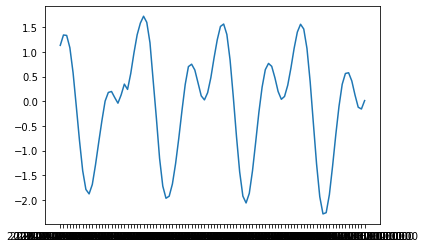

In [13]:
plt.plot(time_test,zeta_test)